In [2]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
from time import time
from tqdm import tqdm as tqdm
import pcmdpy_gpu as ppy
%matplotlib inline

In [37]:
mpl.style.use('seaborn-poster')

In [3]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv_cpu = ppy.driver.Driver(iso_model, gpu=False)
driv_gpu = ppy.driver.Driver(iso_model, gpu=True)

In [4]:
gals = {}
gals['ssp'] = ppy.galaxy.SSPSimple(np.array([0., -2., 2.0, 10.]), dmod=26.0)
gals['tau'] = ppy.galaxy.CustomGalaxy(
    'single',
    'single',
    'tau',
    'variable',
    initial_params=np.array([0., -2.0, 2.0, 3.0, 26.0])
)
gals['taumdf'] = ppy.galaxy.TauFull(np.array([0., -2.0, 2.0, 3.0, 26.0]))

In [5]:
%%time
imf_ssp, _ = iso_model.model_galaxy(gals['ssp'], downsample=5);

CPU times: user 9.72 ms, sys: 0 ns, total: 9.72 ms
Wall time: 9.52 ms


In [6]:
%%time
imf_tau, _ = iso_model.model_galaxy(gals['tau'], downsample=5)

CPU times: user 144 ms, sys: 2.65 ms, total: 146 ms
Wall time: 145 ms


In [7]:
%%time
imf_taumdf, _ = iso_model.model_galaxy(gals['taumdf'], downsample=5)

CPU times: user 856 ms, sys: 477 µs, total: 857 ms
Wall time: 857 ms


In [8]:
len(imf_ssp), len(imf_tau), len(imf_taumdf)

(295, 4757, 28497)

In [9]:
Nims_cpu = [128, 256]
Nims_gpu = [128, 256, 512, 1024, 2048]

In [10]:
times = {}

In [11]:
def time_sim(gal, Nim, psf, gpu, n_sample=5, max_time_sample=60., downsample=5, **kwargs):
    times = []
    if gpu:
        driv = driv_gpu
        # get GPU warmed up
        _ = driv_gpu.simulate(gal, 128, psf=False, downsample=10)
    else:
        driv = driv_cpu
    for i in range(n_sample):
        t_start = time()
        _ = driv.simulate(gal, Nim, downsample=downsample, psf=psf, **kwargs)
        times.append(time() - t_start)
        if times[-1] > max_time_sample:
            break
    return np.median(times), times

In [12]:
def get_times(key):
    gpu_str, gal_str, psf_str = key.split('_')
    gpu = (gpu_str == 'gpu')
    if not gpu: assert gpu_str == 'nogpu'
    if gpu:
        Nims = Nims_gpu
    else:
        Nims = Nims_cpu
    psf = (psf_str == 'psf')
    if not psf: assert psf_str == 'nopsf'
    return np.array([time_sim(gals[gal_str], Nim, psf=psf, gpu=gpu)[0] for Nim in tqdm(Nims, desc=key, leave=False)])

In [13]:
times = {}
for k in ['gpu_ssp_psf', 'gpu_ssp_nopsf', 'gpu_tau_psf', 'gpu_tau_nopsf', 'gpu_taumdf_psf', 'gpu_taumdf_nopsf',
          'nogpu_ssp_psf', 'nogpu_ssp_nopsf']:#, 'nogpu_tau_psf', 'nogpu_tau_nopsf']:#, 'nogpu_taumdf_psf', 'nogpu_taumdf_nopsf']:
    times[k] = get_times(k)

In [14]:
times

{'gpu_ssp_nopsf': [0.5845181941986084,
  0.6030337810516357,
  0.7266902923583984,
  1.1738195419311523,
  3.1556358337402344],
 'gpu_ssp_psf': [0.6455440521240234,
  0.7137446403503418,
  0.9053528308868408,
  1.6028242111206055,
  4.711624383926392],
 'gpu_tau_nopsf': [0.7347838878631592,
  0.7846665382385254,
  0.9787137508392334,
  1.9118716716766357,
  5.578387022018433],
 'gpu_tau_psf': [0.7968916893005371,
  0.8900868892669678,
  1.1814332008361816,
  2.3354785442352295,
  7.137518882751465],
 'gpu_taumdf_nopsf': [1.618697166442871,
  1.9520673751831055,
  3.4551165103912354,
  9.348565578460693,
  33.329111099243164],
 'gpu_taumdf_psf': [1.6548843383789062,
  2.031461000442505,
  3.611848831176758,
  9.793633937835693,
  34.954856157302856],
 'nogpu_ssp_nopsf': [0.41502857208251953, 1.6655681133270264],
 'nogpu_ssp_psf': [0.47525763511657715, 1.7588920593261719]}

Text(0,0.5,'Simulation Time (s)')

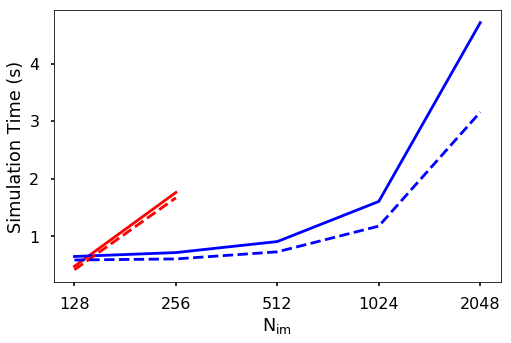

In [40]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(Nims_cpu, times['nogpu_ssp_psf'], color='r')
ax.plot(Nims_gpu, times['gpu_ssp_psf'], color='b')
ax.plot(Nims_cpu, times['nogpu_ssp_nopsf'], color='r', ls='--')
ax.plot(Nims_gpu, times['gpu_ssp_nopsf'], color='b', ls='--')
# ax.plot(Nims_gpu, times['gpu_tau_psf'], color='g')
# ax.plot(Nims_gpu, times['gpu_tau_nopsf'], color='g', ls='--')
# ax.plot(Nims_gpu, times['gpu_taumdf_psf'], color='k')
# ax.plot(Nims_gpu, times['gpu_taumdf_nopsf'], color='k', ls='--')
ax.set_xscale('log')
ax.set_xticklabels([128, 256, 512, 1024, 2048])
ax.minorticks_off()
ax.set_xticks([128, 256, 512, 1024, 2048])
ax.set_xlabel(r'$\mathrm{N}_\mathrm{im}$')
ax.set_ylabel('Simulation Time (s)')

In [43]:
np.array(times['gpu_taumdf_psf'])/np.array(times['gpu_ssp_psf'])

array([2.56354982, 2.84620141, 3.98943783, 6.11023584, 7.41885458])

In [44]:
np.array(times['gpu_tau_psf'])/np.array(times['gpu_ssp_psf'])

array([1.23444974, 1.2470663 , 1.30494229, 1.45710211, 1.51487434])

Text(0,0.5,'Simulation Time (s)')

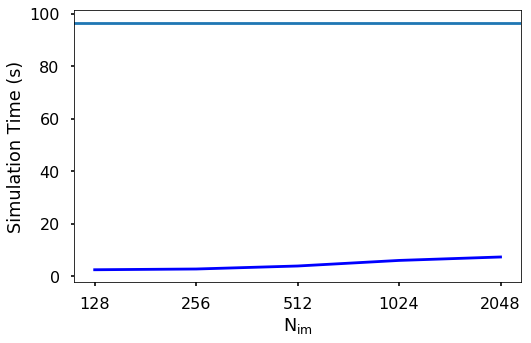

In [42]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(Nims_gpu, np.array(times['gpu_taumdf_psf'])/np.array(times['gpu_ssp_psf']), color='b')
# ax.plot(Nims_gpu, times['gpu_ssp_nopsf'], color='b', ls='--')
# ax.plot(Nims_gpu, times['gpu_tau_psf'], color='g')
# ax.plot(Nims_gpu, times['gpu_tau_nopsf'], color='g', ls='--')
# ax.plot(Nims_gpu, times['gpu_taumdf_psf'], color='k')
# ax.plot(Nims_gpu, times['gpu_taumdf_nopsf'], color='k', ls='--')
ax.axhline(y=len(imf_taumdf)/len(imf_ssp))
ax.set_xscale('log')
ax.set_xticklabels([128, 256, 512, 1024, 2048])
ax.minorticks_off()
ax.set_xticks([128, 256, 512, 1024, 2048])
ax.set_xlabel(r'$\mathrm{N}_\mathrm{im}$')
ax.set_ylabel('Simulation Time (s)')

In [34]:
len(imf_taumdf) / len(imf_tau)

5.990540256464158

In [32]:
np.array(times['gpu_taumdf_psf']) / np.array(times['gpu_tau_psf'])

array([2.07667411, 2.28231763, 3.05717566, 4.19341636, 4.89733992])

In [33]:
np.array(times['gpu_tau_psf']) / np.array(times['gpu_ssp_psf'])

array([1.23444974, 1.2470663 , 1.30494229, 1.45710211, 1.51487434])